In [2]:
import numpy as np
import sympy as sp
from scipy.sparse import coo_matrix, csr_matrix   #for sparse matrix
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
np.set_printoptions(
    precision=4,
    formatter={'float': '{:.4e}'.format}
)


In [3]:
F=np.array([[1,0.1,0],[0,1.1,0],[0,0.2,1]])

def compute_R_and_U(F):
    C=F.T @ F
    la2, nn=np.linalg.eig(C)
    U=np.zeros_like(F)
    for i in range(3):
        U += np.sqrt(la2[i]) * np.outer(nn[:,i],nn[:,i])
    R=F @ np.linalg.inv(U)
    return R, U

R, U=compute_R_and_U(F)

print(f'R= {R}')
J=np.linalg.det(F)

R= [[9.9888e-01 4.7351e-02 -2.2485e-03]
 [-4.7351e-02 9.9438e-01 -9.4703e-02]
 [-2.2485e-03 9.4703e-02 9.9550e-01]]


Show that $$dV=det(F) dV_0$$

In [4]:
#initial cube
dX1,dX2,dX3=sp.symbols('dX1,dX2,dX3',real=True)  
dX1v=sp.Matrix([dX1,0,0])
dX2v=sp.Matrix([0,dX2,0]) 
dX3v=sp.Matrix([0,0,dX3])
#deformation gradient F
F_syms = sp.symbols('F1:4_1:4')   # F11,F12,F13,F21,F22,F23,F31,F32,F33
F = sp.Matrix(3, 3, F_syms)

#deformed vectors
dx1v=F @ dX1v
dx2v=F @ dX2v
dx3v=F @ dX3v

#initial volume
dV0=dX1v.dot(dX2v.cross(dX3v))
#deformed volume
dV=dx1v.dot(dx2v.cross(dx3v))

print(f'deformed volume / initial volume= {sp.simplify(dV/dV0)}')

#verify that det(F)=dV/dV0
detF=sp.Matrix(F).det()
print(f'difference= {sp.simplify(detF-dV/dV0)}')


deformed volume / initial volume= F1_1*(F2_2*F3_3 - F2_3*F3_2) - F2_1*(F1_2*F3_3 - F1_3*F3_2) + F3_1*(F1_2*F2_3 - F1_3*F2_2)
difference= 0


In [5]:
#Problem 5
epsilon_1,epsilon_2,epsilon_3=sp.symbols('epsilon_1,epsilon_2,epsilon_3',real=True)
F=sp.Matrix([[1+epsilon_1,0,0],[0,1+epsilon_2,0],[0,0,1+epsilon_3]])
print(f'det(F)= {sp.simplify(F.det())}')

det(F)= epsilon_1*epsilon_2*epsilon_3 + epsilon_1*epsilon_2 + epsilon_1*epsilon_3 + epsilon_1 + epsilon_2*epsilon_3 + epsilon_2 + epsilon_3 + 1


In [6]:
#Nanson's formula
gamma=sp.symbols('gamma',real=True)
A0=sp.symbols('A0',Positive=True)
F=sp.Matrix([[1,gamma,0],
             [0,1,0],  
             [0,0,1]])

N=sp.Matrix([1,0,0])  #initial normal vector

dA_n=F.det() * F.inv().T @ N * A0
print(f'deformed area vector= {sp.simplify(dA_n)}')

dA=sp.sqrt(dA_n.dot(dA_n))
print(f'deformed area= {sp.simplify(dA)}')
#deformed normal vector
n=dA_n/dA
print(f'deformed normal vector= {sp.simplify(n)}')

deformed area vector= Matrix([[A0], [-A0*gamma], [0]])
deformed area= sqrt(gamma**2 + 1)*sqrt(A0**2)
deformed normal vector= Matrix([[A0/(sqrt(gamma**2 + 1)*sqrt(A0**2))], [-A0*gamma/(sqrt(gamma**2 + 1)*sqrt(A0**2))], [0]])


Code snippet 16

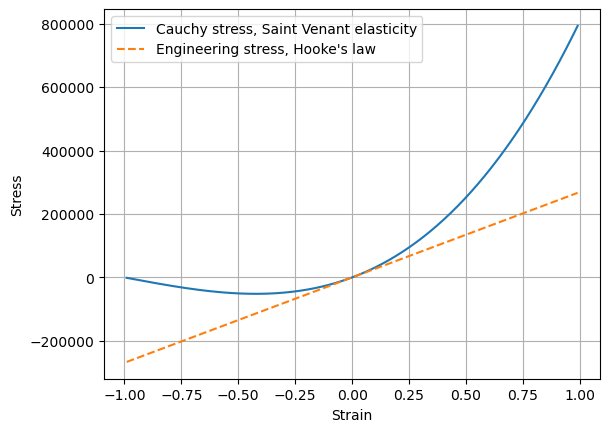

In [7]:
#elastic constants
Emod,v=200e3,0.3  #MPa,.
Gmod=Emod/(2*(1+v))
Kb=Emod/(3*(1-2*v))

#
npoints=200
epsilon=np.linspace(-0.99,0.99,npoints)
sigma_11=np.zeros(npoints)
sigma_11_eng=np.zeros(npoints)

#dev function
dev = lambda E: E - (1/3)*np.trace(E)*np.eye(3)

for i in range(npoints):
    eps11=epsilon[i]
    F=np.array([[1+eps11,0,0],
                [0,1,0],
                [0,0,1]])
    J=np.linalg.det(F)
    C=F.T @ F
    E=0.5*(C - np.eye(3)) #Green-Lagrange strain tensor
    #Saint Venant elasticity model
    S2=Kb * np.trace(E) * np.eye(3) + 2*Gmod * dev(E)
    #Cauchy stress
    sigma= 1/J * F @ S2 @ F.T
    sigma_11[i]=sigma[0,0]
    #engineering strain
    eps_eng=np.zeros((3,3))
    eps_eng[0,0]=eps11
    #Hooke's law for engineering stress
    sigma_eng=Kb * np.trace(eps_eng) * np.eye(3) + 2*Gmod * dev(eps_eng)
    sigma_11_eng[i]=sigma_eng[0,0]

#plot
plt.plot(epsilon,sigma_11,label='Cauchy stress, Saint Venant elasticity')
plt.plot(epsilon,sigma_11_eng,label='Engineering stress, Hooke\'s law',linestyle='dashed')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.legend()
plt.legend()
plt.grid(True)


In [8]:
#Note symbol lambda is reserved in Python
lambd=sp.symbols('lambd',real=True,positive=True)

F=sp.Matrix([[lambd,0,0],
             [0,1/sp.sqrt(lambd),0],
             [0,0,1/sp.sqrt(lambd)]])
C=F.T * F
J=F.det()
Gmod,lambdamod=sp.symbols('Gmod,lambdamod',real=True,positive=True)
S=Gmod*(sp.eye(3)-C.inv())+lambdamod*sp.log(F.det())*C.inv()
sigma=1/F.det()*F * S * F.T
#Here a fcn is created with inputs lambd,Gmod,lambdamod and output sigma
sigma_NH_func = sp.lambdify([lambd, Gmod, lambdamod], sigma, modules='numpy')
print(f'Cauchy stress= {sp.simplify(sigma)}')


Cauchy stress= Matrix([[Gmod*(lambd**2 - 1), 0, 0], [0, -Gmod + Gmod/lambd, 0], [0, 0, -Gmod + Gmod/lambd]])


Create Neo-Hooke routine

In [9]:
#deformation gradient F
F_syms = sp.symbols('F1:4_1:4')   # F11,F12,F13,F21,F22,F23,F31,F32,F33
F = sp.Matrix(3, 3, F_syms)
C=F.T * F
J=F.det()
Gmod,lambdamod=sp.symbols('Gmod,lambdamod',real=True,positive=True)
S=Gmod*(sp.eye(3)-C.inv())+lambdamod*sp.log(F.det())*C.inv()
sigma=1/F.det()*F * S * F.T
#Here a fcn is created with inputs lambd,Gmod,lambdamod and output sigma
sigma_NH_func = sp.lambdify([F, Gmod, lambdamod], sigma, modules='numpy')


#example usage
Emod,v=200e3,0.3  #MPa,.
Gmod=Emod/(2*(1+v))
lambdamod=Emod*v/((1+v)*(1-2*v))
F=np.array([[1+0.1,0,0],
                [0,1,0],
                [0,0,1]])
#Note .ravel() is used to convert F to a 1D array
print(sigma_NH_func(F.ravel(), Gmod, lambdamod))

[[2.4683e+04 0.0000e+00 0.0000e+00]
 [0.0000e+00 9.9976e+03 0.0000e+00]
 [0.0000e+00 0.0000e+00 9.9976e+03]]


Create Yeoh routine

In [10]:
#deformation gradient F
F_syms = sp.symbols('F1:4_1:4')   # F11,F12,F13,F21,F22,F23,F31,F32,F33
F = sp.Matrix(3, 3, F_syms)
C=F.T * F
J=F.det()
Gmod,lambdamod,c2,c3=sp.symbols('Gmod,lambdamod,c2,c3',real=True,positive=True)
S=Gmod*(sp.eye(3)-C.inv())+lambdamod*sp.log(J)*C.inv()+(4*c2*(sp.trace(C)-3)+6*c3*(sp.trace(C)-3)**2)*sp.eye(3);

sigma=1/J*F * S * F.T
print(f'sigma= {sp.simplify(sigma[0,0])}')
#Here a fcn is created with inputs lambd,Gmod,lambdamod and output sigma
sigma_Y_func = sp.lambdify([F, Gmod, lambdamod,c2,c3], sigma, modules='numpy')


sigma= (6*F1_1**6*c3 + 18*F1_1**4*F1_2**2*c3 + 18*F1_1**4*F1_3**2*c3 + 12*F1_1**4*F2_1**2*c3 + 12*F1_1**4*F2_2**2*c3 + 12*F1_1**4*F2_3**2*c3 + 12*F1_1**4*F3_1**2*c3 + 12*F1_1**4*F3_2**2*c3 + 12*F1_1**4*F3_3**2*c3 + 4*F1_1**4*c2 - 36*F1_1**4*c3 + 18*F1_1**2*F1_2**4*c3 + 36*F1_1**2*F1_2**2*F1_3**2*c3 + 24*F1_1**2*F1_2**2*F2_1**2*c3 + 24*F1_1**2*F1_2**2*F2_2**2*c3 + 24*F1_1**2*F1_2**2*F2_3**2*c3 + 24*F1_1**2*F1_2**2*F3_1**2*c3 + 24*F1_1**2*F1_2**2*F3_2**2*c3 + 24*F1_1**2*F1_2**2*F3_3**2*c3 + 8*F1_1**2*F1_2**2*c2 - 72*F1_1**2*F1_2**2*c3 + 18*F1_1**2*F1_3**4*c3 + 24*F1_1**2*F1_3**2*F2_1**2*c3 + 24*F1_1**2*F1_3**2*F2_2**2*c3 + 24*F1_1**2*F1_3**2*F2_3**2*c3 + 24*F1_1**2*F1_3**2*F3_1**2*c3 + 24*F1_1**2*F1_3**2*F3_2**2*c3 + 24*F1_1**2*F1_3**2*F3_3**2*c3 + 8*F1_1**2*F1_3**2*c2 - 72*F1_1**2*F1_3**2*c3 + 6*F1_1**2*F2_1**4*c3 + 12*F1_1**2*F2_1**2*F2_2**2*c3 + 12*F1_1**2*F2_1**2*F2_3**2*c3 + 12*F1_1**2*F2_1**2*F3_1**2*c3 + 12*F1_1**2*F2_1**2*F3_2**2*c3 + 12*F1_1**2*F2_1**2*F3_3**2*c3 + 4*F1_1**2*F2_

In [11]:


#example usage
Emod,v=200e3,0.3  #MPa,.
Gmod=Emod/(2*(1+v))
lambdamod=Emod*v/((1+v)*(1-2*v))
c2=-Gmod/10; c3=Gmod/30;
F=np.array([[1+0.1,0,0],
                [0,1,0],
                [0,0,1]])
#Note .ravel() is used to convert F to a 1D array
print(sigma_Y_func(F.ravel(), Gmod, lambdamod,c2, c3))

[[1.8322e+04 0.0000e+00 0.0000e+00]
 [0.0000e+00 4.7402e+03 0.0000e+00]
 [0.0000e+00 0.0000e+00 4.7402e+03]]


Code snippet 18

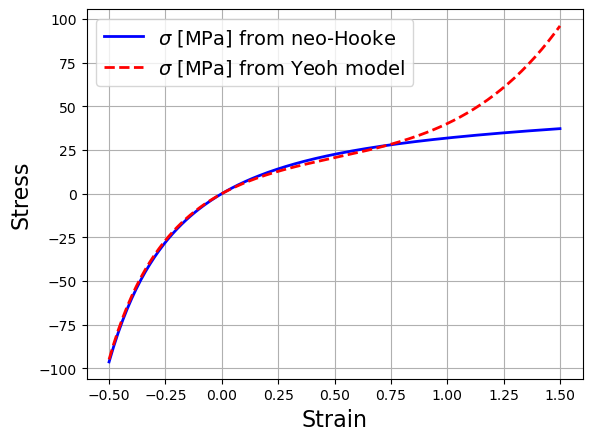

In [12]:
#elastic constants
Emod,v=20,0.45  #MPa,.
Gmod=Emod/(2*(1+v))
lambdamod=Emod*v/((1+v)*(1-2*v))
c2=-Gmod/10; c3=Gmod/30


#
npoints=200
epsilon=np.linspace(-0.5,1.5,npoints)
sigma_11_NH=np.zeros(npoints)
sigma_11_Y=np.zeros(npoints)    


for i in range(npoints):
    eps11=epsilon[i]
    F=np.array([[1+eps11,0,0],
                [0,1,0],
                [0,0,1]])
    #Neo-Hooke model, Cauchy stress
    sigma_NH = sigma_NH_func(F.ravel(), Gmod, lambdamod)
    sigma_11[i]=sigma_NH[0,0]
    #Yeoh model, Cauchy stress
    sigma_Y = sigma_Y_func(F.ravel(), Gmod, lambdamod,c2, c3)
    sigma_11_Y[i]=sigma_Y[0,0]

#plot
plt.rcParams['legend.fontsize'] = 14
plt.plot(epsilon,sigma_11,label=r'$\sigma$ [MPa] from neo-Hooke',color='blue',linewidth=2) 
plt.plot(epsilon,sigma_11_Y,label=r'$\sigma$ [MPa] from Yeoh model',color='red',linestyle='dashed',linewidth=2)
plt.xlabel('Strain',fontsize=16)
plt.ylabel('Stress',fontsize=16)
plt.legend()
plt.legend()
plt.grid(True)

Code snippet 19

In [13]:
#define 2d deformation gradient in Voigt format:
Fv = sp.symbols('Fv1:5',real=True)
#transform to 3x3 format
F=sp.Matrix([[Fv[0],Fv[2],0],[Fv[3],Fv[1],0],[0,0,1]])
# define 3x3 format of P:
Pv = sp.symbols('P1:4_1:4',real=True)
P=sp.Matrix(3, 3, Pv)
#transform to 2d Voigt format
Pv=sp.Matrix([[P[0,0]],[P[1,1]],[P[0,1]],[P[1,0]]])

Code snippet 20

In [14]:
#define isoparametric coordinates and shape functions:
xi = sp.Matrix(sp.symbols('xi1:3',real='true')) #xi1-xi2  
   
#Base functions for constant strain triangle
N1 = 1.-xi[0] - xi[1] ; N2 = xi[0]
N3 = xi[1]
Ne=sp.Matrix([[N1,0,N2,0,N3,0],[0,N1,0,N2,0,N3]])
#produce function in Python
Ne_cst_func=sp.lambdify([xi],Ne )
print(f'Ne at (0.3,0.2)= {Ne_cst_func([0.3,0.2])}')

#differentiate shape functions wrt isoparam. coordinates
dN1_dxi=sp.Matrix([N1]).jacobian(xi).T   
dN2_dxi=sp.Matrix([N2]).jacobian(xi).T
dN3_dxi=sp.Matrix([N3]).jacobian(xi).T

#introduce node positions
Xe1 = sp.Matrix(sp.symbols('Xe1_1:3', real=True))
Xe2 = sp.Matrix(sp.symbols('Xe2_1:3', real=True))
Xe3 = sp.Matrix(sp.symbols('Xe3_1:3', real=True))

#introduce Lagrangian coordinates as fcn of isoparam coordinates
X=N1*Xe1 + N2*Xe2 + N3*Xe3

#compute Jacobian dX/dxi
Fisotr=sp.simplify(X.jacobian(xi))

#element area
Ae0=sp.simplify(0.5*Fisotr.det())
Ae0_cst_func=sp.lambdify([Xe1,Xe2,Xe3],Ae0)

#use chain rule to compute Lagrangiena derivatives
invFisotrT = sp.simplify(Fisotr.inv().T)
dN1_dX=invFisotrT @ dN1_dxi
dN2_dX=invFisotrT @ dN2_dxi
dN3_dX=invFisotrT @ dN3_dxi



#define B0 matrix for constant strain triangle
Be0 = sp.Matrix.zeros(4,6)
Be0=sp.Matrix([[dN1_dX[0], 0, dN2_dX[0], 0, dN3_dX[0], 0],
           [0, dN1_dX[1], 0, dN2_dX[1], 0, dN3_dX[1]],
           [dN1_dX[1], 0, dN2_dX[1], 0, dN3_dX[1], 0],
           [0, dN1_dX[0], 0, dN2_dX[0], 0, dN3_dX[0]]])
           

#produce function in Python
Be0_cst_func=sp.lambdify([Xe1,Xe2,Xe3],Be0 )

Ne at (0.3,0.2)= [[5.0000e-01 0.0000e+00 3.0000e-01 0.0000e+00 2.0000e-01 0.0000e+00]
 [0.0000e+00 5.0000e-01 0.0000e+00 3.0000e-01 0.0000e+00 2.0000e-01]]


Example 4

In [15]:

Xe1n=np.array([0.0,0.0])
Xe2n=np.array([4.0,0.0])
Xe3n=np.array([0.0,3.0])
Be0n=Be0_cst_func(Xe1n,Xe2n,Xe3n)
print(f'Be0 = {Be0n}')

ae=np.array([4+3/2,3/2,3/2+3,3,4+3/2+3/2,3/2]) #example nodal displacements
#F2d=np.array([1,1,0,0]).reshape(-1,1)+Be0n@ae #example 2d deformation gradient in Voigt format
F2d=np.array([1,1,0,0])+Be0n@ae
print(f'F2d= ',F2d)

Be0 = [[-2.5000e-01 0.0000e+00 2.5000e-01 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 -3.3333e-01 0.0000e+00 0.0000e+00 0.0000e+00 3.3333e-01]
 [-3.3333e-01 0.0000e+00 0.0000e+00 0.0000e+00 3.3333e-01 0.0000e+00]
 [0.0000e+00 -2.5000e-01 0.0000e+00 2.5000e-01 0.0000e+00 0.0000e+00]]
F2d=  [7.5000e-01 1.0000e+00 5.0000e-01 3.7500e-01]


Code snippet 21


In [16]:
#define 2d deformation gradient in Voigt format:
Fv = sp.symbols('Fv1:5',real=True)
#transform to 3x3 format
F=sp.Matrix([[Fv[0],Fv[2],0],[Fv[3],Fv[1],0],[0,0,1]])
C=F.T * F
invC=C.inv()
J=F.det()
Gmod,lambdamod=sp.symbols('Gmod,lambdamod')
S=Gmod*(sp.eye(3)-invC)+lambdamod*sp.log(J)*invC
P=F * S
#transform to 2d Voigt format
Pv=sp.Matrix([P[0,0],P[1,1],P[0,1],P[1,0]])
P_NH_func= sp.lambdify([Fv, Gmod, lambdamod], Pv, modules='numpy')


Code snippet 22

In [ ]:
#compute stiffness
dPvdFv=Pv.jacobian(Fv)
#generate function and save for later use
dPdF_NH_func=sp.lambdify([Fv,Gmod,lambdamod],dPvdFv,modules='numpy')